# Colab D1 — PyTorch Lightning — 3-hidden-layer DNN for Non-Linear Regression

**Key requirements satisfied:**
- Synthetic **3-variable** non-linear regression dataset (x1, x2, x3 → y)
- **Deep network with 3 hidden layers**
- Uses **PyTorch Lightning** (`LightningModule`, `Trainer`)
- Built-in backprop/optimization via Lightning (we define loss + optimizer)
- Shows **loss vs epochs** (logged) and **final predicted vs true** output plot
- Includes “4D” visualization: PCA (3D X → 2D) then plot (PC1, PC2, y) with color = x3


In [1]:
# =========================
# Cell 1 — Install + Setup
# =========================
!pip -q install lightning

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import lightning as L
from lightning.pytorch import LightningModule, Trainer
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(7)
torch.manual_seed(7)
L.seed_everything(7, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.6/853.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 22.2 MB/s eta 0:00:00


INFO: Seed set to 7
INFO:lightning.fabric.utilities.seed:Seed set to 7


Device: cpu


In [2]:
# =========================
# Cell 2 — Synthetic data (3 variables) + preprocessing
# =========================
N = 2000
X = np.random.uniform(-2.0, 2.0, size=(N, 3)).astype(np.float32)
x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

noise = 0.10 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(x1)
    + 0.5 * np.cos(x2 * x3)
    + 0.30 * (x2 ** 2)
    - 0.20 * (x3 ** 3)
    + 0.25 * np.sin(x1 * x2)
    + noise
).astype(np.float32).reshape(-1, 1)

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardize for stable training
X_mu, X_std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
y_mu, y_std = y_train.mean(axis=0, keepdims=True), y_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - X_mu) / X_std
X_test_n  = (X_test  - X_mu) / X_std
y_train_n = (y_train - y_mu) / y_std
y_test_n  = (y_test  - y_mu) / y_std

print("Shapes:", X_train_n.shape, y_train_n.shape, X_test_n.shape, y_test_n.shape)


Shapes: (1600, 3) (1600, 1) (400, 3) (400, 1)


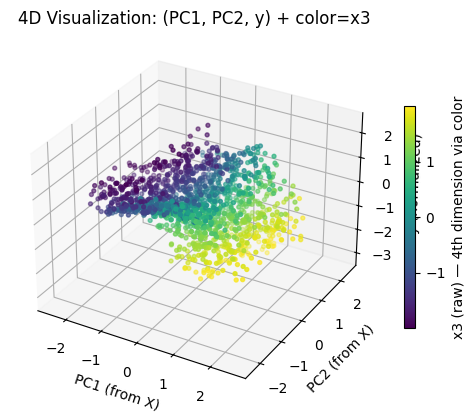

In [3]:
# =========================
# Cell 3 — 4D visualization (PCA for X, color = x3)
# =========================
pca = PCA(n_components=2, random_state=7)
X2 = pca.fit_transform(X_train_n)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X2[:, 0], X2[:, 1], y_train_n[:, 0], c=X_train[:, 2], s=8)

ax.set_xlabel("PC1 (from X)")
ax.set_ylabel("PC2 (from X)")
ax.set_zlabel("y (normalized)")
fig.colorbar(sc, ax=ax, shrink=0.6, label="x3 (raw) — 4th dimension via color")
plt.title("4D Visualization: (PC1, PC2, y) + color=x3")
plt.show()


In [4]:
# =========================
# Cell 4 — LightningModule (3 hidden layers)
# =========================
class LitDeepRegressor(LightningModule):
    def __init__(self, lr=0.01, in_dim=3, h1=32, h2=32, h3=16):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Linear(in_dim, h1),
            nn.Tanh(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h3),
            nn.Tanh(),
            nn.Linear(h3, 1)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.criterion(yhat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        yhat = self(x)
        loss = self.criterion(yhat, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [5]:
# =========================
# Cell 5 — DataLoaders + Train with Trainer
# =========================
# Split train into train/val
X_tr, X_val, y_tr, y_val = train_test_split(X_train_n, y_train_n, test_size=0.2, random_state=7)

train_ds = TensorDataset(torch.tensor(X_tr,  dtype=torch.float32), torch.tensor(y_tr,  dtype=torch.float32))
val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False, num_workers=0)

model = LitDeepRegressor(lr=0.01)

trainer = Trainer(
    max_epochs=300,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    log_every_n_steps=10,
    enable_checkpointing=False,
    enable_model_summary=True
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: 💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ net       │ Sequential │  1.7 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 1.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.7 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 9                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


Test MSE (normalized): 0.013672
Test MSE (original scale): 0.014734


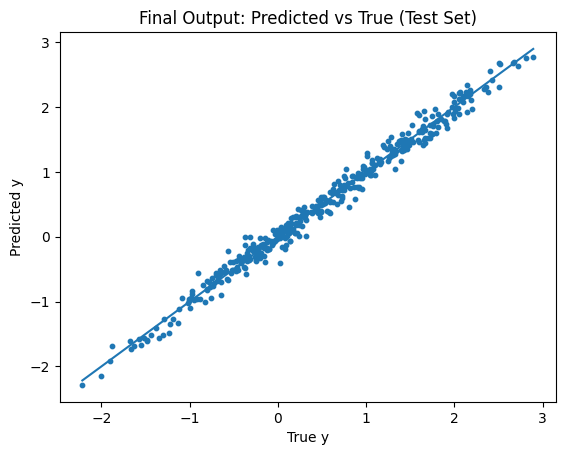

Sample 0: true= 0.0281 | pred=-0.0199
Sample 1: true= 1.2483 | pred= 1.4692
Sample 2: true=-0.7661 | pred=-0.7731
Sample 3: true= 1.8116 | pred= 1.6903
Sample 4: true= 1.6677 | pred= 1.8084


In [6]:
# =========================
# Cell 6 — Evaluation + final output plots
# =========================
Xte = torch.tensor(X_test_n, dtype=torch.float32)
yte = torch.tensor(y_test_n, dtype=torch.float32)

model.eval()
with torch.no_grad():
    yhat_n = model(Xte).numpy()
    test_mse_n = float(np.mean((yhat_n - y_test_n) ** 2))

# Unnormalize
yhat = (yhat_n * y_std + y_mu).reshape(-1, 1)
ytrue = y_test
test_mse = float(np.mean((yhat - ytrue) ** 2))

print(f"Test MSE (normalized): {test_mse_n:.6f}")
print(f"Test MSE (original scale): {test_mse:.6f}")

plt.figure()
plt.scatter(ytrue, yhat, s=10)
mn, mx = float(ytrue.min()), float(ytrue.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Final Output: Predicted vs True (Test Set)")
plt.show()

for i in range(5):
    print(f"Sample {i}: true={ytrue[i,0]: .4f} | pred={yhat[i,0]: .4f}")
